In [1]:
# !pip install transformers
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from collections import defaultdict
import pandas as pd
import numpy as np
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

from nltk.stem.snowball import SnowballStemmer
st = SnowballStemmer('english')

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [2]:
torch.cuda.is_available()

True

## Load data

In [3]:

df=pd.read_csv("IMDB Dataset.csv")

**Check the head of df**

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Pre-processing

In [7]:
def to_sentiment(rating):
  if rating == 'positive':
    return 1
  else:
    return 0
df['sentiment'] = df.sentiment.apply(to_sentiment)

### Preprocessing Function

In [8]:
def processText(df):
    processed_Reviews = []
    for review in df.review:
        # original
        # print(review)

        # set all as lowercase
        lowerCase = review.lower()

        # tokenize
        tokens = nltk.word_tokenize(lowerCase)

        # remove punctuation
        regex = re.compile(f'[{re.escape(string.punctuation)}]')
        tokens_NoPunct = [regex.sub('', word) for word in tokens if not regex.sub('', word) == '']

        # removing stopwords
        stop_words = stopwords.words('english')
        stop_words.append('via')
        tokens_NoStopWords = [token for token in tokens_NoPunct if token not in stop_words]

        # remove links
        regex = re.compile('http\S+')
        tokens_NoLinks = [regex.sub('', word) for word in tokens_NoStopWords if not regex.sub('', word) == '' and not word.startswith('tc')]

        # Lemmatizing
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens_NoLinks]

        # Detokenizing
        untokenized = TreebankWordDetokenizer().detokenize(lemmatized_words)

        processed_Reviews.append(untokenized)
    return processed_Reviews

In [9]:
processed_Reviews = processText(df)
df['processedReview'] = processed_Reviews

In [10]:
df.head()

,review,sentiment,processedReview
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stunnin...


## Data Split


#### Train Test Validation Split

In [12]:
X = df.drop(columns='sentiment')
y = df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify= y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=123, stratify= y_train)


print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

1    17500
0    17500
Name: sentiment, dtype: int64
0    2500
1    2500
Name: sentiment, dtype: int64
0    5000
1    5000
Name: sentiment, dtype: int64


### Checking lengths of reviews

In [13]:
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
# tokens_lens = []

# for txt in df.review:
#   tokens = tokenizer.encode(txt, max_length = 512)
#   tokens_lens.append(len(tokens))

In [15]:
# sns.distplot(tokens_lens)
# plt.xlim([0, 256]);
# plt.xlabel('Token count');

# Classification Using BERT

### Custom Dataset Class & Dataloader Function

In [16]:
class IMDBReviewsDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = self.reviews[item]
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = self.max_len,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_token_type_ids = False,
        return_tensors = 'pt',  # Return PyTorch tensors
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def create_data_loader(features, classification, tokenizer, max_len, batch_size, reviewType):

  if reviewType == 0:
    reviews = features.review.to_numpy()
  else:
    reviews = features.processedReview.to_numpy()

  dataset = IMDBReviewsDataset(
      reviews = reviews,
      targets = classification.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      dataset,
      batch_size = batch_size,
      num_workers = 0
  )

#### Creating Dataloaders

In [17]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(X_train, y_train, tokenizer, 50, 16, 1)
val_data_loader = create_data_loader(X_val, y_val, tokenizer, 50, 16, 1)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, 50, 16, 1)

### Classifier

##### Classifier NN Module

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()


    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    
    self.out = nn.Sequential(
      nn.Linear(768, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, n_classes),
    )

  def forward(self, input_ids, attention_mask):
    bm = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      
    )
    output = self.drop(bm['pooler_output'])
    return self.out(output)

cuda:0


##### Model Training

In [19]:
model = SentimentClassifier(2)
model = model.to(device)

EPOCHS = 5

optimizer = optim.Adam(model.parameters(), lr=5e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )


    # print("outputs: ", outputs)
    _,preds = torch.max(outputs, dim=1)
    # print("max: ", preds)
    loss = loss_fn(outputs,targets)

    correct_predictions += torch.sum(preds == targets)
    # print("correct_predictions: ", correct_predictions)
    losses.append(loss.item())
  
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    last_lr = scheduler.get_last_lr()

  return correct_predictions.double() / n_examples , np.mean(losses), last_lr


In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():

    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _,preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print('Epoch', epoch + 1,'/', EPOCHS)
  print('----------')

  train_acc, train_loss, last_lr = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(X_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(X_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['learn_rate'].append(last_lr)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1 / 5
----------
Train loss 0.5258654576932272 accuracy 0.7607142857142857
Val   loss 0.47944326379809515 accuracy 0.8082
Epoch 2 / 5
----------


In [ ]:
historyCopy = history
trainAccuracyValues = []
valAccuracyValues = []
for tensor in historyCopy['train_acc']:
    trainAccuracyValues.append(tensor.item())

for tensor in historyCopy['val_acc']:
    valAccuracyValues.append(tensor.item())



(0.7, 1.0)

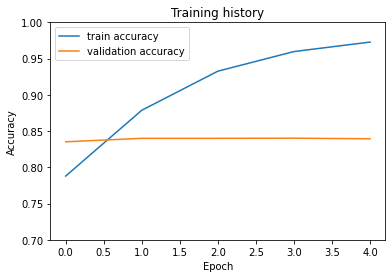

In [ ]:

plt.plot(trainAccuracyValues, label='train accuracy')
plt.plot(valAccuracyValues, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.7, 1])

In [ ]:
lrHistory = []
for tensor in historyCopy['learn_rate']:
    lrHistory.append(tensor.item())
plt.plot(lrHistory, label='Learning Rates')
plt.ylim = [0, 1]

### Results

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
      
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

class_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      5000
    positive       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



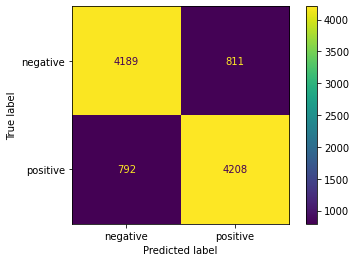

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()